In [1]:
import keras
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import SVG
from IPython.display import display

import random

Using TensorFlow backend.


In [2]:
# Load image data
imgdat_glass = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_glass.npy')
imgdat_paper = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_paper.npy')
imgdat_cardboard = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_cardboard.npy')
imgdat_plastic = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_plastic.npy')
imgdat_metal = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_metal.npy')
imgdat_trash = np.load('/nfshome/sandbox/TrashNet-Dataset/imgdat_trash.npy')

# Make sure the data loaded correctly
print(imgdat_glass.shape)
print(imgdat_paper.shape)
print(imgdat_cardboard.shape)
print(imgdat_plastic.shape)
print(imgdat_metal.shape)
print(imgdat_trash.shape)

(501, 100, 100, 3)
(594, 100, 100, 3)
(403, 100, 100, 3)
(482, 100, 100, 3)
(410, 100, 100, 3)
(137, 100, 100, 3)


In [103]:
# Concatenate image data for input to network
X = np.concatenate((imgdat_glass, imgdat_paper, imgdat_cardboard, 
                   imgdat_plastic, imgdat_metal, imgdat_trash))

# Mean-center all image data
#for i in range(X.shape[0]):
#    X[i] = (X[i] - X.mean(axis = 0)) / X.std(axis = 0) # center image data
X = (X - X.mean()) / X.std()

# Load in the labels and convert to one-hot encoding
with open('/nfshome/sandbox/TrashNet-Dataset/labels.csv', 'r', encoding = 'utf-8') as f:
    labels = f.read().split(',')
Y = keras.utils.to_categorical(labels)

# Now we'll split the input and labels into groups again.
# We'll shuffle these categories separately so that we can ensure both
# training and testing sets have some images from each category.
imgdat_lens = [imgdat_glass.shape[0], imgdat_paper.shape[0], imgdat_cardboard.shape[0],
               imgdat_plastic.shape[0], imgdat_metal.shape[0], imgdat_trash.shape[0]]
X_categories = []
Y_categories = []

index_start = 0
for imgdat_len in imgdat_lens:
    index_end = index_start + imgdat_len
    X_categories = X_categories + [X[index_start : index_end]]
    Y_categories = Y_categories + [Y[index_start : index_end]]
    index_start = index_end
    
X_train = np.array([])
X_test = np.array([])
Y_train = np.array([])
Y_test = np.array([])

X_train.shape = (0, 100, 100, 3)
X_test.shape = (0, 100, 100, 3)
Y_train.shape = (0, 6)
Y_test.shape = (0, 6)

# Shuffle both X and Y
for i in range(len(X_categories)):
    for j in range(X_categories[i].shape[0]):
        randIndex = random.randint(0, X_categories[i].shape[0] - 1)

        # Swap X
        tempX = X_categories[i][j]
        X_categories[i][j] = X_categories[i][randIndex]
        X_categories[i][randIndex] = tempX

        # Swap Y
        tempY = Y_categories[i][j]
        Y_categories[i][j] = Y_categories[i][randIndex]
        Y_categories[i][randIndex] = tempY
    
    # Split the shuffled categories equally into training and testing sets
    half = int(X_categories[i].shape[0] / 2)
    X_train = np.concatenate((X_train, X_categories[i][0 : half]))
    X_test = np.concatenate((X_test, X_categories[i][half : ]))
    Y_train = np.concatenate((Y_train, Y_categories[i][0 : half]))
    Y_test = np.concatenate((Y_test, Y_categories[i][half : ]))
    
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_train shape: " + str(Y_train.shape))
print("Y_test shape: " + str(Y_test.shape))
print("X_train + X_test size: " + str(X_train.shape[0] + X_test.shape[0]))
print("Y_train + Y_test size: " + str(Y_train.shape[0] + Y_test.shape[0]))

X shape: (2527, 100, 100, 3)
Y shape: (2527, 6)
X_train shape: (1262, 100, 100, 3)
X_test shape: (1265, 100, 100, 3)
Y_train shape: (1262, 6)
Y_test shape: (1265, 6)
X_train + X_test size: 2527
Y_train + Y_test size: 2527


In [106]:
model = keras.Sequential()

# Bottleneck to keep parameters low
model.add(keras.layers.Conv2D(24, kernel_size = (1, 1), # squeeze
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None),
                              input_shape = [100, 100, 3]))
model.add(keras.layers.Conv2D(24, kernel_size = (4, 4), # map 
                              activation = 'relu',
                              bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.4, seed = None)))
model.add(keras.layers.Conv2D(32, kernel_size = (1, 1), # expand
                             activation = 'relu',
                             bias_initializer = keras.initializers.RandomUniform(minval = 0.001, maxval = 0.2, seed = None)))
model.add(keras.layers.MaxPooling2D(pool_size = (3, 3)))

model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(Y.shape[1], activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.001),
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 100, 100, 24)      96        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 97, 97, 24)        9240      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 97, 97, 32)        800       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 196614    
Total para

In [107]:
history = model.fit(X_train, Y_train, batch_size = 100, 
                    epochs = 20, verbose = 0, validation_split = 0.3, 
                    callbacks = [TQDMNotebookCallback()])
print('Accuracy: ', model.evaluate(X, Y)[1] * 100.0, '%')

2527/2527 [==============================] - 20s 8ms/step
Accuracy:  73.64463791056589 %


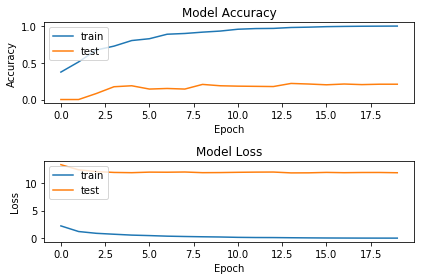

In [109]:
plt.figure(1)

# Accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

# Loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

plt.tight_layout()
plt.show()

In [110]:
preds = model.predict(X_test)

[ 0.01236081 99.66737     0.22595157  0.09431804  0.          0.        ]
[0. 1. 0. 0. 0. 0.]


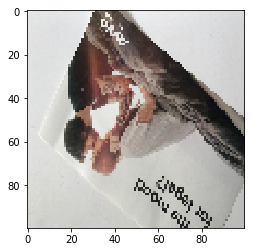

In [133]:
np.set_printoptions(suppress = True)
print(preds[300] * 100.0)
print(Y_test[300])

plt.imshow(keras.preprocessing.image.array_to_img(X_train[300, :, :, :]))
plt.show()